# Probability IV: Gaussian Processes
### Implemented in Python

<i>Patrick White</i></br>
<i>Dec 31, 2024</i>

<img src="img/gp1.png" style="height: 400px; width:auto;">

# Outline

- What are Gaussian Processes?
- Working with the MVN Distribution
- GPs as Distributions Over Functions
- Kernels
- Marginalization
- Conditioning
- GP Regression Implementation
- Prediction
- Posterior
- Scikit-Learn Implementation

# What are Gaussian Processes (GPs)?

GPs originate from the field of probability theory, and offer a robust and flexible framework for modeling complex data. They are special (and perhaps unintuitive) in several ways:

- They utilize a Multivariate Normal (MVN) probability distribution function.
- They are inherently Bayesian, involving a prior and posterior distribution.
- They represent a distribution over functions rather than finite parameter values.
- They are infinite-dimensional, until updated with data (and then n-dimensional).

GP regression has been long-used in the geostatistics field, where it is known as kriging, and has been traditionally applied in mining, hydrology, environmental science, agriculture, and meteorology. In optimization and simulation applications, GP regression can be used to create surrogate models that approximate expensive-to-evaluate functions. 

Gaussian processes provide the best linear unbiased predictor (BLUP) of a variable at unobserved locations based on observed data and spatial correlation structure. Other analytical justifications include that they are non-parametric, and can therefore approximate any continuous function, that they are interpreted probabilistically and estimate uncertainty, and that the marginal likelihood can be optimized using hyperparameters (within the kernel function of the covariance matrix).

# Working With the MVN Distribution

GPs involve working with the multivariate Gaussian, in which a random vector $X = (X_1, …, X_k)$ has if every linear combination of the $X_j$ has a Gaussian distribution. The MVN has the nice properties that the marginal densities, conditional densities, and sum of independent random variables is also Gaussian. As the MVN is the multivariate generalization of the Gaussian, the GP is an infinite-dimensional generalization of the MVN. Gaussians also have the nice property of being closed under conditioning and marginalization, making problems in machine learning tractable.

$\mathcal{N}(\mathbf{y} | \mathbf{\mu}, \mathbf{\Sigma}) = \frac{1}{ (2 \pi)^{D/2} |\mathbf{\Sigma}|^{1/2} } ~exp \left[ -\frac{1}{2} (\mathbf{y} - \mathbf{\mu})^T \mathbf{\Sigma}^{-1} (\mathbf{y} - \mathbf{\mu}) \right]$

- $D$ is the number of dimensions

The MVN is fully specified if the mean vector $\mathbf{\mu}$ and covariance matrix $\mathbf{\Sigma}$ are known. We can use the covariance matrix to encode information via a kernel function, which may be linear, non-linear, or periodic. Bayesian regression can be thought of as the special case in which we use a linear kernel function,

$k(x, x') = x^T x'$

# GPs as a Distribution Over Functions

One can think of the GP's kernel function and hyperparameters as defining a distribution over functions, and inference taking place in the space of a random field. A random field is a collection of random variables indexed by spatial or temporal coordinates, and in spatial contexts, describes how a variable varies across a region. As in probabilistic linear regression, we assume samples can be modeled by some function plus Gaussian noise.

# Kernels

Assume we can model a variable $Y$ as a function $f$ of $X$ plus some Gaussian noise.

$Y \sim \mathcal{N}(\mu=f(X), \sigma=\varepsilon)$

If $f$ is a linear function of $X$, then this assumption is essentially the same as simple linear regression. If we use a more general expression for $f$ by setting a prior over it, we will be able to get more complex functions than linear. If we decided to use Gaussian processes as the prior, we can write:

$f(X) = \mathcal{GP}(\mu_X, \mathcal{K}(\mathbf{X}, \mathbf{X'}))$

A variety of kernel functions are available, such as the following:

<img src="img/gp1-1.png" style="height: 400px; width:auto;">

- Play around with this at https://distill.pub/2019/visual-exploration-gaussian-processes/

For the periodic kernel, we have parameter p, which determines periodicity, and with the linear kernel, we have parameter c, which allows us to change the point on which all functions hinge. A kernel could be implemented as a mixture (a multiplication or addition) of multiple kernel functions.

A more extensive discussion of kernels can be found at <a href="www.cs.toronto.edu/~durenaud/cookbook">www.cs.toronto.edu/~durenaud/cookbook</a>.

# Marginalization

GPs define a probability distribution over possible functions in such as way that, at each point you evaluate a function, it places a Gaussian distribution with given mean and variance. This distribution is commonly centered to revolve around $\mathbf{\mu} = \mathbf{0}$.

Through marginalization, we can extract partial information from multivariate distributions. Given a Gaussian probability distribution $P_{X,Y}$ over vectors of random variables $X$ and $Y$,

- $X \sim \mathcal{N}(\mathbf{\mu}_X, \mathbf{\Sigma}_{XX})$

- $Y \sim \mathcal{N}(\mathbf{u}_Y, \mathbf{\Sigma}_{YY})$

Each partition $X$ and $Y$ only depends on its corresponding entries in $\mu$ and $\mathbf{\Sigma}$. To marginalize out a random variable from a Gaussian distribution, we can simply drop the variables from $\mu$ and $\mathbf{\Sigma}$.

$p_X(x) = \int_y p_{X,Y}(x,y) ~dy = \int_y p_{X,Y}(x|y) ~p_Y(y) ~dy$

The interpretation is that if we are interested in the probability density of $X = x$, we need to consider all possible outcomes of $Y$ that can jointly lead to the result.

# Conditioning

Conditioning is used to determine the probability of one variable depending on another variable. Similar to marginalization, this operation is closed and yields a modified Gaussian distribution. 

- $X|Y \sim \mathcal{N} (\mathbf{\mu}_X + \mathbf{\Sigma}_{XY} \mathbf{\Sigma}_{YY}^{-1} (Y - \mathbf{\mu}_Y), \mathbf{\Sigma}_{XX} - \mathbf{\Sigma_{XY} \mathbf{\Sigma}_{YY}^{-1} \mathbf{\Sigma}_{YX}})$

- $Y|X \sim \mathcal{N} (\mathbf{\mu}_Y + \mathbf{\Sigma}_{YX} \mathbf{\Sigma}_{XX}^{-1} (X - \mathbf{\mu}_X), \mathbf{\Sigma}_{YY} - \mathbf{\Sigma}_{YX} \mathbf{\Sigma}_{XX}^{-1} \mathbf{\Sigma}_{XY})$

We form the joint distribution $P_{X,Y}$ between the test points $X$ and the training points $Y$, resulting in a multivariate Gaussian with dimensions $|Y|+|X|$. We concatenate the training and test points to compute the corresponding covariance matrix. Under conditioning, we can find $P_{X|Y}$ from $P_{X,Y}$.

# GP Regression Implementation

Below, we'll implement Gaussian process regression. I'll start by creating some training data to work with.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


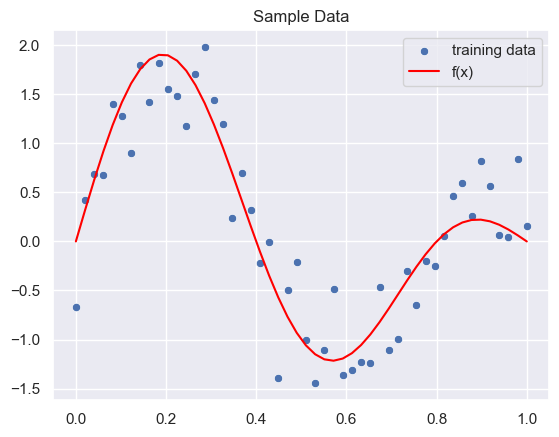

In [2]:
n = 50
x = np.linspace(start=0, stop=1, num=n)

def f(x):
    f = np.sin((3*np.pi)*x) + np.sin((2*np.pi)*x)
    return(f)

f_x = f(x)

sigma_n = 0.4
epsilon = np.random.normal(loc=0, scale=sigma_n, size=n)
y = f_x + epsilon

fig, ax = plt.subplots()
sns.scatterplot(x=x, y=y, label='training data', ax=ax);
sns.lineplot(x=x, y=f_x, color='red', label='f(x)', ax=ax);
ax.set(title='Sample Data')
ax.legend(loc='upper right');

Then, define a kernel function. There are many options, but we'll simply go with the radial basis function (RBF), which bears similarity to the univariate Gaussian, and is parameterized by $\sigma_f$ and $\ell$.

- $\text{Cov}(f(x_p), f(x_q)) = k_{\sigma_f, \ell}(x_p, x_q) = \sigma_f \exp\left(-\frac{1}{2\ell^2} ||x_p - x_q||^2\right)$

In [3]:
def kernel_function(x, y, sigma_f=1, l=1):
    kernel = sigma_f * np.exp(- (np.linalg.norm(x - y)**2) / (2 * l**2))
    return kernel

# Prediction

We form the joint distribution $P_{X_*,X}$ between the test points $X_*$ and the training points $X$, resulting in a multivariate Gaussian with dimensions $|X|+|X_*|$. We concatenate the training and test points to compute the corresponding covariance matrix. Under conditioning, we can find $P_{X_*|X}$ from $P_{X_*,X}$.

The joint distribution of $y$ and $f_*$ is given by:

$
\begin{bmatrix}
y \\ 
f_* \\
\end{bmatrix}
\sim \mathcal{N}(0, C)
$

where

- $C = \begin{bmatrix} K(X, X) + \sigma^2_n I & K(X, X_*) \\ K(X_*, X) & K(X_*, X_*) \\ \end{bmatrix}$

- $\sigma_n^2 I$ is a term to account for noise.

First, we select parameters and compute the covariance matrices.

In [4]:
# Adapted from https://juanitorduz.github.io/gaussian_process_reg/

import itertools

n_star = 50
x_star = np.linspace(start=0, stop=1, num=n_star)

# parameters
l = 0.1
sigma_f = 2

def compute_cov_matrices(x, x_star, sigma_f=1, l=1):
    """
    K = K(X, X) 
    K_star = K(X_*, X)
    K_star2 = K(X_*, X_*)
    """
    n = x.shape[0]
    n_star = x_star.shape[0]
    K = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x, x)]
    K = np.array(K).reshape(n, n)
    K_star2 = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x_star, x_star)]
    K_star2 = np.array(K_star2).reshape(n_star, n_star)
    K_star = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x_star, x)]
    K_star = np.array(K_star).reshape(n_star, n)    
    return (K, K_star2, K_star)

K, K_star2, K_star = compute_cov_matrices(x, x_star, sigma_f=sigma_f, l=l)

Then, concatenate the covariance matrices together.

(100, 50)
(100, 50)
(100, 100)


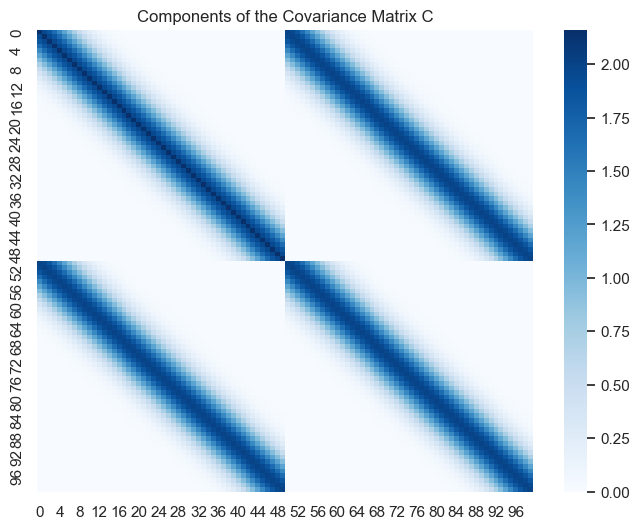

In [5]:
a = np.concatenate((K + (sigma_n**2)*np.eye(n), K_star), axis=0)
print(a.shape)

b = np.concatenate((K_star.T, K_star2), axis=0)
print(b.shape)

C = np.concatenate((a, b), axis=1)
print(C.shape)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(data=C, cmap='Blues', ax=ax)
ax.set(title='Components of the Covariance Matrix C');

We can draw samples from the prior if we'd like, to see what kind of functions we are likely to observe.

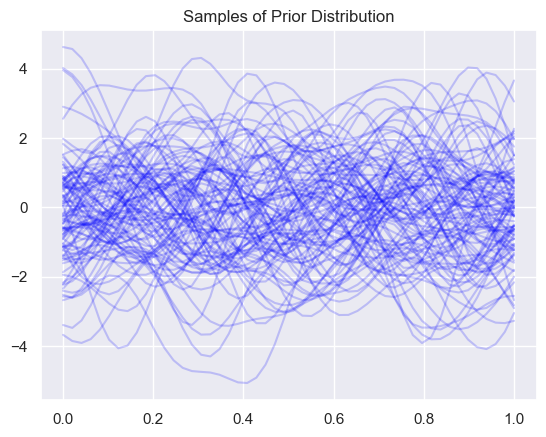

In [7]:
import warnings
warnings.filterwarnings('ignore')

fig, ax = plt.subplots()

for i in range(0, 100):
    z_star = np.random.multivariate_normal(mean=np.zeros(n_star), cov=K_star2)
    sns.lineplot(x=x_star, y=z_star, color='blue', alpha=0.2, ax=ax)
    
ax.set(title='Samples of Prior Distribution');

# Posterior

To get the posterior distribution over functions, we need to restrict this joint prior distribution to contain only those functions which agree with the observed data points. We are interested in computing $f_*|X, y, X_*$. These can be found as:

$f_*|X, y, X_* \sim \mathcal{N}(\bar{f}_*, \text{cov}(f_*))$

where

- $\bar{f}_* = K(X_*, X)(K(X, X) + \sigma^2_n I)^{-1} y$

- $\text{Cov}(f_*) = K(X_*, X_*) - K(X_*, X)(K(X, X) + \sigma^2_n I)^{-1} K(X, X_*)$

Below, we compute these parameters and then visualize the covariance matrix resulting from the calculation.

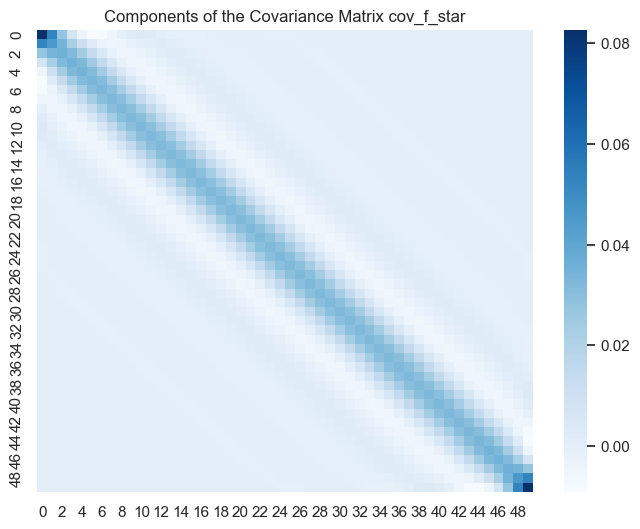

In [8]:
def compute_gpr_parameters(K, K_star2, K_star, sigma_n):
    n = K.shape[0]
    f_bar_star = np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), y.reshape([n, d])))
    cov_f_star = K_star2 - np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), K_star.T))
    
    return (f_bar_star, cov_f_star)

# dimensions
d = 1
f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star2, K_star, sigma_n)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(data=cov_f_star, cmap='Blues', ax=ax)
ax.set_title('Components of the Covariance Matrix cov_f_star');

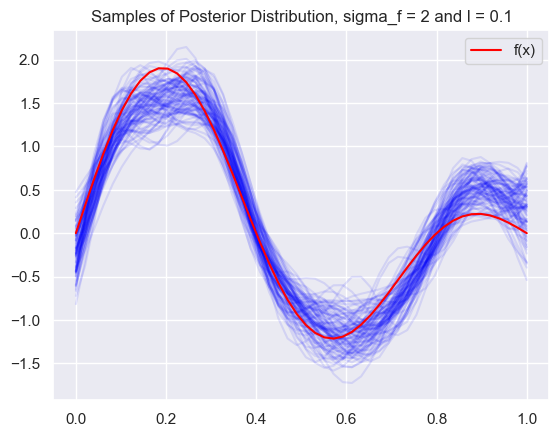

In [9]:
fig, ax = plt.subplots()

for i in range(0, 100):
    # Sample from posterior distribution. 
    z_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)

    sns.lineplot(x=x_star, y=z_star, color="blue", alpha=0.1, ax=ax);
    
# Plot "true" linear fit.
sns.lineplot(x=x, y=f_x, color='red', label = 'f(x)', ax=ax)
ax.set(title=f'Samples of Posterior Distribution, sigma_f = {sigma_f} and l = {l}')
ax.legend(loc='upper right');

# Scikit-Learn Implementation

Below, we'll use the scikit-learn implementation, and extend the x-axis in order to predict the future, showing a confidence interval which reflects 3 standard deviations from the predicted mean.

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

In [11]:
# Set dimension. 
d = 1

# Length of the training set. 
L = 1

# Generate training features.
x = np.linspace(start=0, stop=L, num=n)
X = x.reshape(n, d)

# Generate noise
sigma_n = 0.4
epsilon = np.random.normal(loc=0, scale=sigma_n, size=n)

f_x = f(x)
y = f_x + epsilon

In [12]:
n_star = n + 50
x_star = np.linspace(start=0, stop=(L + 0.25), num=n_star)

X_star = x_star.reshape(n_star, d)

# Define kernel parameters. 
l = 0.01
sigma_f = 1

# Define kernel object. 
kernel = ConstantKernel(constant_value=sigma_f, constant_value_bounds=(1e-2, 1e2)) \
            * RBF(length_scale=l, length_scale_bounds=(1e-2, 1e2))

gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n**2, n_restarts_optimizer=10, )
gp.fit(X, y)
y_pred = gp.predict(X_star)

In [13]:
# Generate samples from posterior distribution. 
y_hat_samples = gp.sample_y(X_star, n_samples=n_star)

# Compute the mean of the sample. 
y_hat = np.apply_over_axes(func=np.mean, a=y_hat_samples, axes=1).squeeze()

# Compute the standard deviation of the sample. 
y_hat_sd = np.apply_over_axes(func=np.std, a=y_hat_samples, axes=1).squeeze()

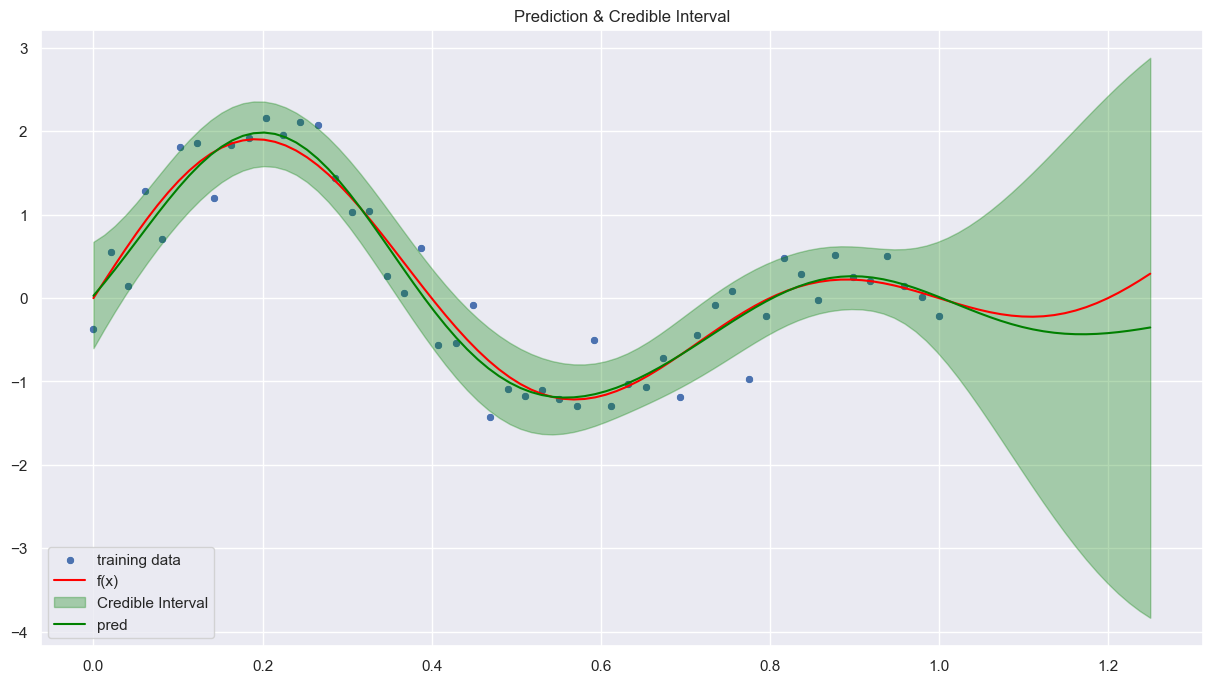

In [14]:
fig, ax = plt.subplots(figsize=(15, 8))

sns.scatterplot(x=x, y=y, label='training data', ax=ax);

sns.lineplot(
    x=x_star, 
    y=f(x_star), 
    color='red', 
    label='f(x)', 
    ax=ax
)

ax.fill_between(
    x=x_star, 
    y1=(y_hat - 3*y_hat_sd), 
    y2=(y_hat + 3*y_hat_sd), 
    color='green',
    alpha=0.3, 
    label='Credible Interval'
)

sns.lineplot(x=x_star, y=y_pred, color='green', label='pred')
ax.set(title='Prediction & Credible Interval')
ax.legend(loc='lower left');

# References

- Rasumussen, C., & Williams, C. (2006). Gaussian Processes for Machine Learning (2nd ed.). MIT Press. https://gaussianprocess.org/gpml/chapters/RW.pdf

- Gramacy, R. B. (2020). Surrogates: Gaussian process modeling, design and optimization for the applied sciences. CRC Press. https://bookdown.org/rbg/surrogates/

- Gortler, J., Kehlbeck, R., & Deussen, O. (2019, April 2). A Visual Exploration of Gaussian Processes. Distill. https://distill.pub/2019/visual-exploration-gaussian-processes/

- (2019, September 21). An Introduction to Gaussian Process Regression. Juanitorduz.Github.io. https://juanitorduz.github.io/gaussian_process_reg/

- Murphy, K. P. (2022). Probablistic Machine Learning (2nd ed.). MIT Press. https://probml.github.io/pml-book/book1.html

- Roberts, S., Osborne, M., Ebden, M., Reece, S., Gibson, N., & Aigrain, S. (2012). Gaussian Processes for Timeseries Modelling. University of Oxford. https://www.robots.ox.ac.uk/~sjrob/Pubs/philTransA_2012.pdf

- [Youtube]. Freitas, N. D. (2013, February 4). Machine learning - Introduction to Gaussian processes [Video]. UBC. https://www.youtube.com/watch?v=4vGiHC35j9s&list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6&index=9

- [Youtube]. Freitas, N. D. (2013, February 5). Machine learning - Gaussian processes [Video]. UBC. https://www.youtube.com/watch?v=MfHKW5z-OOA&list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6&index=10

- (n.d.). Interactive Gaussian Process Visualization. Infinitely Curious. http://www.infinitecuriosity.org/vizgp/